In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2

In [2]:
# !pip install git+https://github.com/FacePerceiver/facer.git@main

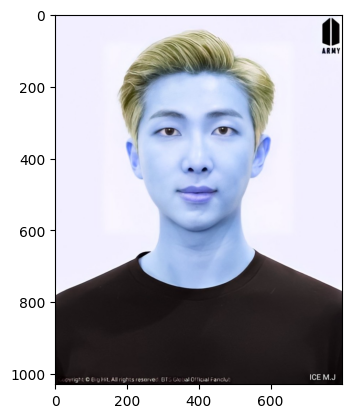

In [7]:
img_path = './test/rm.jpeg'
img = cv2.imread(img_path)

plt.imshow(img)

In [7]:
# !git clone https://github.com/FacePerceiver/facer.git

Cloning into 'facer'...
remote: Enumerating objects: 384, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 384 (delta 5), reused 5 (delta 5), pack-reused 376
Receiving objects: 100% (384/384), 2.99 MiB | 13.61 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Encountered 16 file(s) that should have been pointers, but weren't:
	samples/data/fire.webp
	samples/data/girl.jpg
	samples/data/sideface.jpg
	samples/data/twogirls.jpg
	samples/data/weirdface.jpg
	samples/data/weirdface2.jpg
	samples/data/weirdface3.jpg
	samples/download.ipynb
	samples/example_output/alignment.png
	samples/example_output/detect.png
	samples/example_output/parsing.png
	samples/face_alignment.ipynb
	samples/face_attribute.ipynb
	samples/face_detect.ipynb
	samples/face_parsing.ipynb
	samples/transform.ipynb


In [ ]:
# !pip install timm

In [8]:
import torch
import timm
import facer

/Users/ohs/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [9]:
torch.cuda.is_available(), torch.cuda.device_count()

(False, 0)

Downloading: "https://github.com/elliottzheng/face-detection/releases/download/0.0.1/mobilenet0.25_Final.pth" to /Users/ohs/.cache/torch/hub/checkpoints/mobilenet0.25_Final.pth
100%|██████████| 1.71M/1.71M [00:00<00:00, 3.63MB/s]


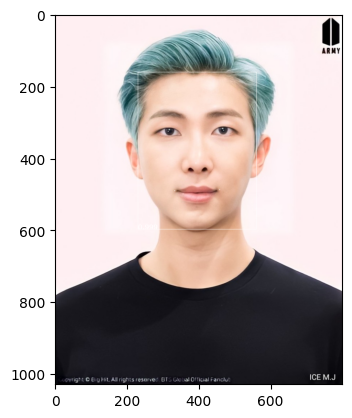

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
image = facer.hwc2bchw(facer.read_hwc(img_path)).to(device=device)

face_detector = facer.face_detector('retinaface/mobilenet', device=device)

with torch.inference_mode():
    faces = face_detector(image)

facer.show_bchw(facer.draw_bchw(image, faces))

In [11]:
face_parser = facer.face_parser('farl/lapa/448', device=device)
with torch.inference_mode():
    faces = face_parser(image, faces)

Downloading: "https://github.com/FacePerceiver/facer/releases/download/models-v1/face_parsing.farl.lapa.main_ema_136500_jit191.pt" to /Users/ohs/.cache/torch/hub/checkpoints/face_parsing.farl.lapa.main_ema_136500_jit191.pt
100%|██████████| 617M/617M [03:01<00:00, 3.56MB/s] 


torch.Size([1, 11, 1029, 800])


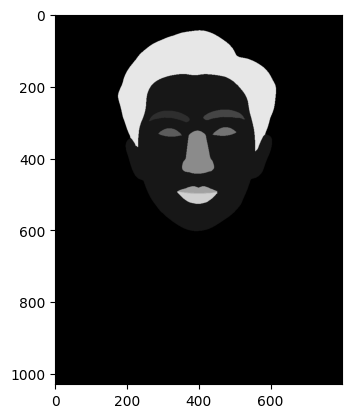

In [12]:
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)

print(seg_probs.shape)

facer.show_bhw(seg_probs.argmax(dim=1).float()/seg_logits.size(1) * 255)

In [13]:
seg_logits.shape,seg_probs.shape, seg_probs.argmax(dim=1).shape

(torch.Size([1, 11, 1029, 800]),
 torch.Size([1, 11, 1029, 800]),
 torch.Size([1, 1029, 800]))

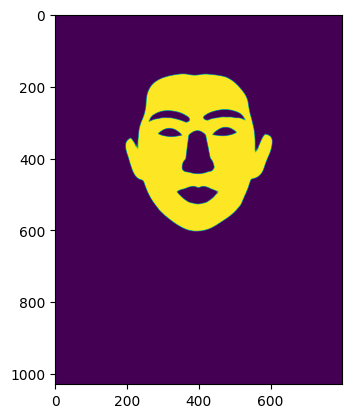

In [14]:
seg_probs = seg_probs.cpu()
tensor = seg_probs.permute(0, 2, 3, 1)
tensor = tensor.squeeze().numpy()
face_skin = tensor[:, :, 1]
plt.imshow(face_skin)

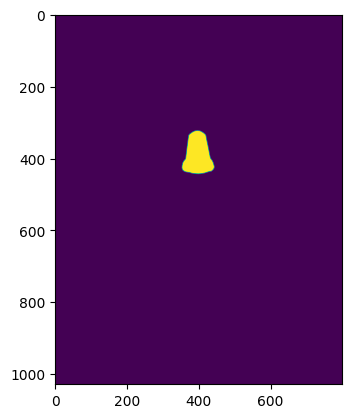

In [15]:
third_channel = tensor[:, :, 6]
plt.imshow(third_channel)

In [16]:
binary_mask = (face_skin >= 0.5).astype(int)
np.unique(binary_mask)

array([0, 1])

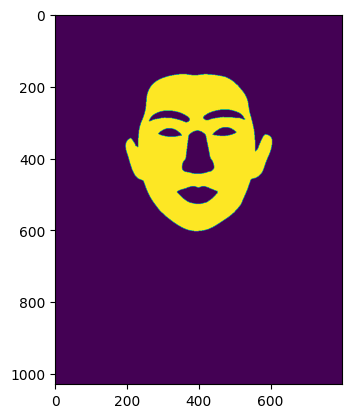

In [17]:
plt.imshow(binary_mask)

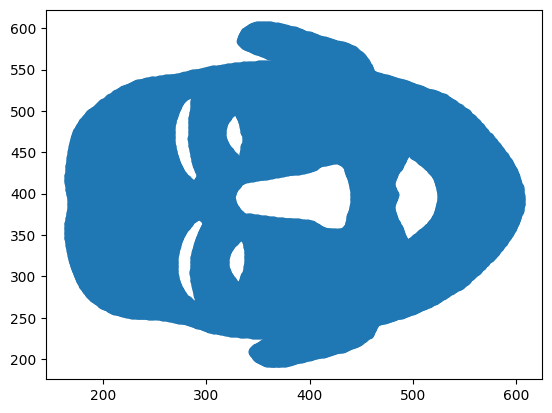

In [18]:
x, y = np.nonzero(binary_mask > 0)#visualize
plt.scatter(x, y)

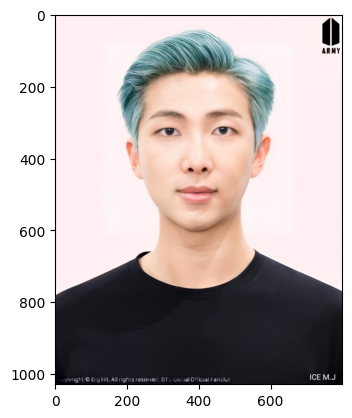

In [19]:
res = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(res)

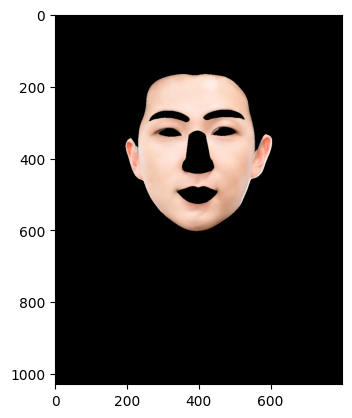

In [20]:
masked_image = np.zeros_like(res)
masked_image[binary_mask == 1] = res[binary_mask == 1] #visualize
plt.imshow(masked_image)